# Aiida

https://github.com/BAMresearch/NFDI4IngScientificWorkflowRequirements

## Define workflow with aiida

In [1]:
import os

In [2]:
from python_workflow_definition.aiida import write_workflow_json

from aiida_workgraph import WorkGraph, task
from aiida import orm, load_profile
load_profile()

Profile<uuid='38168b192f654d6c9515c186d57ce4e1' name='pwd'>

In [3]:
from workflow import (
    generate_mesh,
    convert_to_xdmf as _convert_to_xdmf,
    poisson as _poisson,
    plot_over_line,
    substitute_macros,
    compile_paper,
)

In [4]:
convert_to_xdmf = task(outputs=["xdmf_file", "h5_file"])(_convert_to_xdmf)
poisson = task(outputs=["numdofs", "pvd_file", "vtu_file"])(_poisson)

In [5]:
source_directory = orm.Str(os.path.abspath(os.path.join(os.curdir, "source")))

In [6]:
domain_size = orm.Float(2.0)

In [7]:
wg = WorkGraph("wg-nfdi")

In [8]:
gmsh_output_file = wg.add_task(
    generate_mesh,
    name="generate_mesh",
    domain_size=domain_size,
    source_directory=source_directory,
)

In [9]:
meshio_output_dict = wg.add_task(
    convert_to_xdmf,
    name="convert_to_xdmf",
    gmsh_output_file=gmsh_output_file.outputs.result,
)

In [10]:
poisson_dict = wg.add_task(
    poisson,
    name="poisson",
    meshio_output_xdmf=meshio_output_dict.outputs.xdmf_file, 
    meshio_output_h5=meshio_output_dict.outputs.h5_file,
    source_directory=source_directory,
)

In [11]:
pvbatch_output_file = wg.add_task(
    plot_over_line,
    name="plot_over_line",
    poisson_output_pvd_file=poisson_dict.outputs.pvd_file, 
    poisson_output_vtu_file=poisson_dict.outputs.vtu_file,
    source_directory=source_directory,
)

In [12]:
macros_tex_file = wg.add_task(
    substitute_macros,
    name="substitute_macros",
    pvbatch_output_file=pvbatch_output_file.outputs.result, 
    ndofs=poisson_dict.outputs.numdofs, 
    domain_size=domain_size,
    source_directory=source_directory,
)

In [13]:
paper_output = wg.add_task(
    compile_paper,
    name="compile_paper",
    macros_tex=macros_tex_file.outputs.result, 
    plot_file=pvbatch_output_file.outputs.result,
    source_directory=source_directory,
)

In [14]:
wg

NodeGraphWidget(settings={'minimap': True}, style={'width': '90%', 'height': '600px'}, value={'name': 'wg-nfdi…

In [15]:
workflow_json_filename = "aiida_nfdi.json"

In [16]:
write_workflow_json(wg=wg, file_name=workflow_json_filename)

In [17]:
!cat {workflow_json_filename}

{
  "nodes": [
    {
      "id": 0,
      "type": "function",
      "value": "workflow.generate_mesh"
    },
    {
      "id": 1,
      "type": "function",
      "value": "workflow.convert_to_xdmf"
    },
    {
      "id": 2,
      "type": "function",
      "value": "workflow.poisson"
    },
    {
      "id": 3,
      "type": "function",
      "value": "workflow.plot_over_line"
    },
    {
      "id": 4,
      "type": "function",
      "value": "workflow.substitute_macros"
    },
    {
      "id": 5,
      "type": "function",
      "value": "workflow.compile_paper"
    },
    {
      "id": 6,
      "type": "input",
      "name": "domain_size",
      "value": 2.0
    },
    {
      "id": 7,
      "type": "input",
      "name": "source_directory",
      "value": "/home/jovyan/example_workflows/nfdi/source"
    },
    {
      "id": 8,
      "type": "output",
      "name": "result"
    }
  ],
  "edges": [
    {
      "target": 1,
      "targetPort": "gmsh_output_file",
      "source": 0,


## Load Workflow with jobflow

In [18]:
from python_workflow_definition.jobflow import load_workflow_json

In [19]:
from jobflow.managers.local import run_locally

In [20]:
flow = load_workflow_json(file_name=workflow_json_filename)

In [21]:
result = run_locally(flow)
result

2025-05-14 08:19:05,840 INFO Started executing jobs locally
2025-05-14 08:19:06,092 INFO Starting job - generate_mesh (2b5d3769-0843-43a0-b074-2b307413b932)
2025-05-14 08:19:07,248 INFO Finished job - generate_mesh (2b5d3769-0843-43a0-b074-2b307413b932)
2025-05-14 08:19:07,249 INFO Starting job - convert_to_xdmf (60d93a50-60c8-4ebc-9822-fae5e9f6bf4b)
2025-05-14 08:19:08,519 INFO Finished job - convert_to_xdmf (60d93a50-60c8-4ebc-9822-fae5e9f6bf4b)
2025-05-14 08:19:08,521 INFO Starting job - poisson (06a30fcc-b3e5-4223-aa6e-1090166cd9c7)
2025-05-14 08:19:11,239 INFO Finished job - poisson (06a30fcc-b3e5-4223-aa6e-1090166cd9c7)
2025-05-14 08:19:11,240 INFO Starting job - plot_over_line (f899080b-495a-401e-a71c-3abba9e81a5b)
2025-05-14 08:19:12,690 INFO Finished job - plot_over_line (f899080b-495a-401e-a71c-3abba9e81a5b)
2025-05-14 08:19:12,691 INFO Starting job - substitute_macros (b1612cb4-0027-4140-95c2-8cb7581109ca)
2025-05-14 08:19:13,570 INFO Finished job - substitute_macros (b1612c

{'2b5d3769-0843-43a0-b074-2b307413b932': {1: Response(output='/home/jovyan/example_workflows/nfdi/preprocessing/square.msh', detour=None, addition=None, replace=None, stored_data=None, stop_children=False, stop_jobflow=False, job_dir=PosixPath('/home/jovyan/example_workflows/nfdi'))},
 '60d93a50-60c8-4ebc-9822-fae5e9f6bf4b': {1: Response(output={'xdmf_file': '/home/jovyan/example_workflows/nfdi/preprocessing/square.xdmf', 'h5_file': '/home/jovyan/example_workflows/nfdi/preprocessing/square.h5'}, detour=None, addition=None, replace=None, stored_data=None, stop_children=False, stop_jobflow=False, job_dir=PosixPath('/home/jovyan/example_workflows/nfdi'))},
 '06a30fcc-b3e5-4223-aa6e-1090166cd9c7': {1: Response(output={'numdofs': 357, 'pvd_file': '/home/jovyan/example_workflows/nfdi/processing/poisson.pvd', 'vtu_file': '/home/jovyan/example_workflows/nfdi/processing/poisson000000.vtu'}, detour=None, addition=None, replace=None, stored_data=None, stop_children=False, stop_jobflow=False, job_

## Load Workflow with pyiron_base

In [22]:
from python_workflow_definition.pyiron_base import load_workflow_json

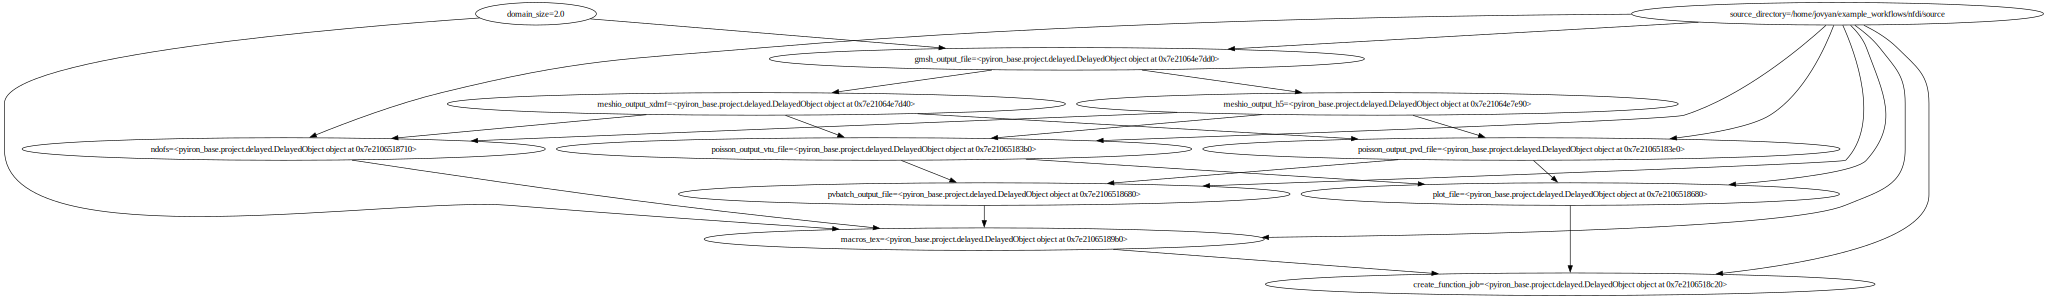

In [23]:
delayed_object_lst = load_workflow_json(file_name=workflow_json_filename)
delayed_object_lst[-1].draw()

In [24]:
delayed_object_lst[-1].pull()

The job generate_mesh_47725c16637f799ac042e47468005db3 was saved and received the ID: 1
The job convert_to_xdmf_d6a46eb9a4ec352aa996e783ec3c785f was saved and received the ID: 2
The job poisson_3c147fc86db87cf0c0f94bda333f8cd8 was saved and received the ID: 3
The job plot_over_line_ef50933291910dadcc8311924971e127 was saved and received the ID: 4
The job substitute_macros_63766eafd6b1980c7832dd8c9a97c96e was saved and received the ID: 5
The job compile_paper_128d1d58374953c00e95b8de62cbb10b was saved and received the ID: 6


'/home/jovyan/example_workflows/nfdi/postprocessing/paper.pdf'